Reached r = 384442.6 km at t = 32099700.0 s
t_days = 371.52 days
Final mass mf = 890.89 kg
Propellant used = 109.11 kg


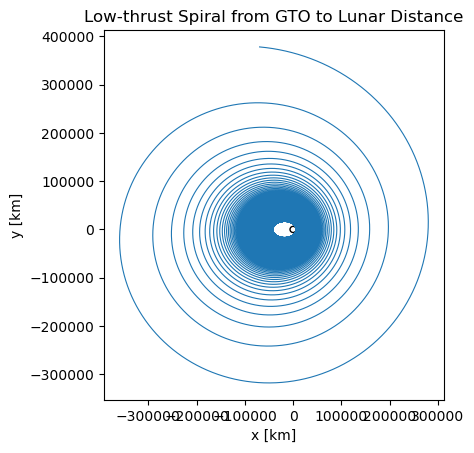

In [5]:
import math
import matplotlib.pyplot as plt

# --- Constants ---
mu = 398600.4418   # km^3/s^2
Re = 6378.0        # km

# GTO geometry
rp = Re + 200.0    # km
ra = Re + 36000.0  # km
a0 = 0.5 * (rp + ra)

# Perigee speed on the elliptic GTO
vp0 = math.sqrt(mu * (2.0/rp - 1.0/a0))

# Thruster / spacecraft
T_N = 0.1          # N
Isp = 3000.0       # s
g0  = 9.80665      # m/s^2
m0  = 1000.0       # kg

rf = 384400.0      # km target radius

# Mass flow rate (engine always on)
mdot = -T_N / (Isp * g0)   # kg/s

def deriv(state):
    """Return time derivative (dx, dy, dvx, dvy, dm)."""
    x, y, vx, vy, m = state
    r = math.hypot(x, y)

    # Gravity
    ax_g = -mu * x / r**3
    ay_g = -mu * y / r**3

    # Tangential thrust (aligned with velocity)
    v = math.hypot(vx, vy)
    if m <= 0 or v == 0.0:
        ax_t = ay_t = 0.0
        dm = 0.0
    else:
        # Thrust acceleration magnitude in km/s^2
        aT = (T_N / m) / 1000.0
        ax_t = aT * (vx / v)
        ay_t = aT * (vy / v)
        dm = mdot

    return (vx, vy, ax_g + ax_t, ay_g + ay_t, dm)

def rk4_step(state, dt):
    k1 = deriv(state)
    s2 = tuple(state[i] + 0.5*dt*k1[i] for i in range(5))
    k2 = deriv(s2)
    s3 = tuple(state[i] + 0.5*dt*k2[i] for i in range(5))
    k3 = deriv(s3)
    s4 = tuple(state[i] + dt*k3[i] for i in range(5))
    k4 = deriv(s4)
    return tuple(
        state[i] + dt*(k1[i] + 2*k2[i] + 2*k3[i] + k4[i])/6.0
        for i in range(5)
    )

# Initial state at perigee of elliptic GTO
state = (rp, 0.0, 0.0, vp0, m0)
t = 0.0

dt = 300.0          # time step [s]
max_steps = 200_000

xs, ys = [], []

for step in range(max_steps):
    x, y, vx, vy, m = state
    r = math.hypot(x, y)
    xs.append(x)
    ys.append(y)
    if r >= rf:
        break
    state = rk4_step(state, dt)
    t += dt

x, y, vx, vy, mf = state
r_final = math.hypot(x, y)

print(f"Reached r = {r_final:.1f} km at t = {t:.1f} s")
print(f"t_days = {t/86400:.2f} days")
print(f"Final mass mf = {mf:.2f} kg")
print(f"Propellant used = {m0 - mf:.2f} kg")

# Plot orbit
fig, ax = plt.subplots()
ax.plot(xs, ys, linewidth=0.8)
earth = plt.Circle((0, 0), Re, fill=False)
ax.add_artist(earth)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('Low-thrust Spiral from GTO to Lunar Distance')
plt.show()


--- Constant tangential thrust ---
Reached r = 384442.6 km at t = 32099700.0 s
t_days = 371.52 days
Final mass mf = 890.89 kg
Propellant used = 109.11 kg
Engine-on time = 371.52 days



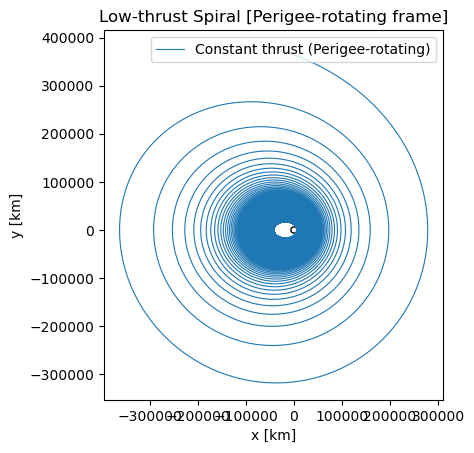

--- 90° thrust arc (±45° about perigee) ---
Reached r = 389660.2 km at t = 25467300.0 s
t_days = 294.76 days
Final mass mf = 991.93 kg
Propellant used = 8.07 kg
Engine-on time = 27.09 days



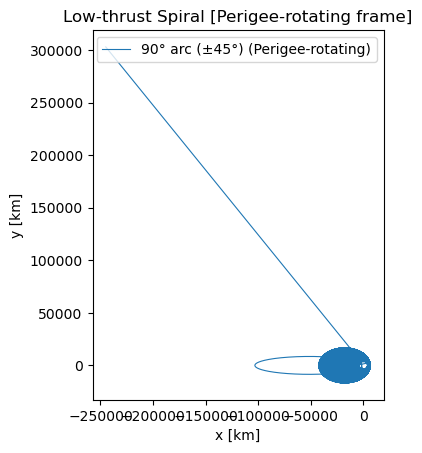

--- 180° thrust arc (±90° about perigee) ---
Reached r = 393093.4 km at t = 35874900.0 s
t_days = 415.22 days
Final mass mf = 971.06 kg
Propellant used = 28.94 kg
Engine-on time = 98.81 days



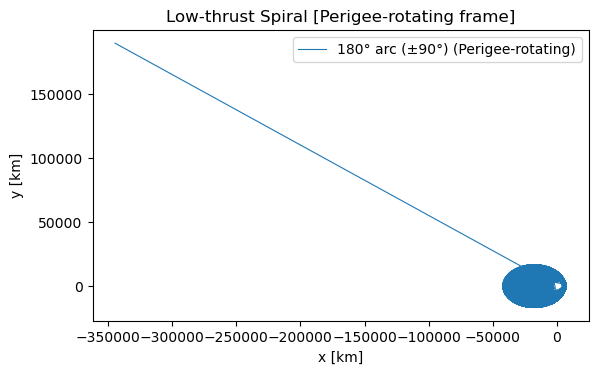

In [ ]:
import math
import matplotlib.pyplot as plt

# --- Constants ---
mu = 398600.4418   # km^3/s^2
Re = 6378.0        # km

# GTO geometry
rp = Re + 200.0    # km
ra = Re + 36000.0  # km
a0 = 0.5 * (rp + ra)

# Perigee speed on the elliptic GTO
vp0 = math.sqrt(mu * (2.0 / rp - 1.0 / a0))

# Thruster / spacecraft
T_N = 0.1          # N
Isp = 3000.0       # s
g0  = 9.80665      # m/s^2
m0  = 1000.0       # kg

rf = 384400.0      # km target radius (Moon distance)

# Mass flow rate (negative, engine ON)
mdot = -T_N / (Isp * g0)   # kg/s


# -----------------------------
# True anomaly & rotating-frame helpers
# -----------------------------
def true_anomaly_from_state(x, y, vx, vy):
    """Return osculating true anomaly (rad) for planar motion."""
    r = math.hypot(x, y)
    if r == 0.0:
        return 0.0
    hz = x*vy - y*vx
    vxh_x = vy*hz
    vxh_y = -vx*hz
    rhat_x = x / r
    rhat_y = y / r
    ex = vxh_x / mu - rhat_x
    ey = vxh_y / mu - rhat_y
    e = math.hypot(ex, ey)
    if e < 1e-8:
        return 0.0
    dot_er = ex*x + ey*y
    cosnu = max(-1.0, min(1.0, dot_er / (e * r)))
    nu = math.acos(cosnu)
    vr = (x*vx + y*vy) / r
    if vr < 0.0:
        nu = -nu
    return nu

def thrust_allowed(state, arc_half_width_rad):
    if arc_half_width_rad is None:
        return True
    x, y, vx, vy, _ = state
    nu = true_anomaly_from_state(x, y, vx, vy)
    return abs(nu) <= arc_half_width_rad

def perigee_angle(state):
    """Return argument of periapsis (rad) for planar orbit."""
    x, y, vx, vy, _ = state
    r = math.hypot(x, y)
    if r == 0.0:
        return 0.0
    hz = x*vy - y*vx
    vxh_x = vy*hz
    vxh_y = -vx*hz
    rhat_x = x / r
    rhat_y = y / r
    ex = vxh_x / mu - rhat_x
    ey = vxh_y / mu - rhat_y
    if math.hypot(ex, ey) < 1e-8:
        return math.atan2(y, x)
    return math.atan2(ey, ex)

def rotate_to_perigee_frame(state):
    x, y, vx, vy, _ = state
    omega = perigee_angle(state)
    cos_w = math.cos(omega)
    sin_w = math.sin(omega)
    x_rot = x * cos_w + y * sin_w
    y_rot = -x * sin_w + y * cos_w
    return x_rot, y_rot


# -----------------------------
# Derivative maker + RK4
# -----------------------------
def make_deriv(arc_half_width_deg=None):
    if arc_half_width_deg is not None:
        arc_half_width_rad = math.radians(arc_half_width_deg)
    else:
        arc_half_width_rad = None

    def deriv(state):
        x, y, vx, vy, m = state
        r = math.hypot(x, y)

        ax_g = -mu * x / r**3
        ay_g = -mu * y / r**3

        thrust_on = thrust_allowed(state, arc_half_width_rad) and m > 0

        v = math.hypot(vx, vy)
        if thrust_on and v > 0.0:
            aT = (T_N / m) / 1000.0
            ax_t = aT * (vx / v)
            ay_t = aT * (vy / v)
            dm = mdot
        else:
            ax_t = ay_t = 0.0
            dm = 0.0

        return (vx, vy, ax_g + ax_t, ay_g + ay_t, dm)

    return deriv


def rk4_step(deriv, state, dt):
    k1 = deriv(state)
    s2 = tuple(state[i] + 0.5 * dt * k1[i] for i in range(5))
    k2 = deriv(s2)
    s3 = tuple(state[i] + 0.5 * dt * k2[i] for i in range(5))
    k3 = deriv(s3)
    s4 = tuple(state[i] + dt * k3[i] for i in range(5))
    k4 = deriv(s4)
    return tuple(
        state[i] + dt * (k1[i] + 2*k2[i] + 2*k3[i] + k4[i]) / 6.0
        for i in range(5)
    )


# -----------------------------
# Propagation helper
# -----------------------------
def simulate(arc_half_width_deg=None, dt=300.0, max_steps=400_000,
             store_trajectory=False, log_history=False):
    if arc_half_width_deg is not None:
        arc_half_width_rad = math.radians(arc_half_width_deg)
    else:
        arc_half_width_rad = None

    deriv = make_deriv(arc_half_width_deg)

    state = (rp, 0.0, 0.0, vp0, m0)
    t = 0.0
    thrust_time = 0.0

    xs, ys = [], []
    xs_rot, ys_rot = [], []
    xs_thrust, ys_thrust = [], []
    xs_thrust_rot, ys_thrust_rot = [], []
    if store_trajectory:
        def store_point(target_list, data):
            target_list[0].append(data[0])
            target_list[1].append(data[1])
        store_point((xs, ys), (state[0], state[1]))
        xr, yr = rotate_to_perigee_frame(state)
        store_point((xs_rot, ys_rot), (xr, yr))

    history = {"r": [], "thrust_on": []} if log_history else None

    for step in range(max_steps):
        x, y, vx, vy, m = state
        r = math.hypot(x, y)

        thrusting_now = thrust_allowed(state, arc_half_width_rad) and m > 0

        if history is not None:
            history["r"].append(r)
            history["thrust_on"].append(thrusting_now)

        if r >= rf:
            break

        if thrusting_now:
            thrust_time += dt
            if store_trajectory:
                xs_thrust.append(x)
                ys_thrust.append(y)
                xr, yr = rotate_to_perigee_frame(state)
                xs_thrust_rot.append(xr)
                ys_thrust_rot.append(yr)

        state = rk4_step(deriv, state, dt)
        t += dt

        if store_trajectory:
            xs.append(state[0])
            ys.append(state[1])
            xr, yr = rotate_to_perigee_frame(state)
            xs_rot.append(xr)
            ys_rot.append(yr)

    x, y, vx, vy, mf = state
    r_final = math.hypot(x, y)

    return {
        "t": t,
        "t_days": t / 86400.0,
        "mf": mf,
        "r_final": r_final,
        "xs": xs if store_trajectory else None,
        "ys": ys if store_trajectory else None,
        "xs_rot": xs_rot if store_trajectory else None,
        "ys_rot": ys_rot if store_trajectory else None,
        "xs_thrust": xs_thrust if store_trajectory else None,
        "ys_thrust": ys_thrust if store_trajectory else None,
        "xs_thrust_rot": xs_thrust_rot if store_trajectory else None,
        "ys_thrust_rot": ys_thrust_rot if store_trajectory else None,
        "thrust_time": thrust_time,
        "history": history,
        "dt": dt,
    }


# -----------------------------
# Plot helper
# -----------------------------
def plot_trajectory(res, label, frame="rotating", thrust_only=False):
    if frame == "rotating" and res["xs_rot"] is not None:
        xs = res["xs_rot"]
        ys = res["ys_rot"]
        xs_th = res["xs_thrust_rot"]
        ys_th = res["ys_thrust_rot"]
        frame_label = "Perigee-rotating"
    else:
        xs = res["xs"]
        ys = res["ys"]
        xs_th = res["xs_thrust"]
        ys_th = res["ys_thrust"]
        frame_label = "Inertial"

    fig, ax = plt.subplots()
    if thrust_only:
        ax.plot(xs_th, ys_th, linewidth=1.0, label=f"{label} thrust arcs")
    else:
        ax.plot(xs, ys, linewidth=0.4, color="tab:gray", label=f"{label} coast", alpha=0.4)
        ax.plot(xs_th, ys_th, linewidth=1.2, color="tab:blue", label=f"{label} thrust")
    earth = plt.Circle((0, 0), Re, fill=False)
    ax.add_artist(earth)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x [km]')
    ax.set_ylabel('y [km]')
    ax.set_title(f'Low-thrust Spiral [{frame_label}]')
    ax.legend()
    plt.show()


# -----------------------------
# Run the three cases
# -----------------------------

res_const = simulate(arc_half_width_deg=None, store_trajectory=True, log_history=True)

print("--- Constant tangential thrust ---")
print(f"Reached r = {res_const['r_final']:.1f} km at t = {res_const['t']:.1f} s")
print(f"t_days = {res_const['t_days']:.2f} days")
print(f"Final mass mf = {res_const['mf']:.2f} kg")
print(f"Propellant used = {m0 - res_const['mf']:.2f} kg")
print(f"Engine-on time = {res_const['thrust_time']/86400:.2f} days\n")

plot_trajectory(res_const, "Constant thrust", frame="rotating", thrust_only=False)

res_90 = simulate(arc_half_width_deg=45.0, store_trajectory=True, log_history=True)

print("--- 90° thrust arc (±45° about perigee) ---")
print(f"Reached r = {res_90['r_final']:.1f} km at t = {res_90['t']:.1f} s")
print(f"t_days = {res_90['t_days']:.2f} days")
print(f"Final mass mf = {res_90['mf']:.2f} kg")
print(f"Propellant used = {m0 - res_90['mf']:.2f} kg")
print(f"Engine-on time = {res_90['thrust_time']/86400:.2f} days\n")

plot_trajectory(res_90, "90° arc (±45°)", frame="rotating", thrust_only=True)

res_180 = simulate(arc_half_width_deg=90.0, store_trajectory=True, log_history=True)

print("--- 180° thrust arc (±90° about perigee) ---")
print(f"Reached r = {res_180['r_final']:.1f} km at t = {res_180['t']:.1f} s")
print(f"t_days = {res_180['t_days']:.2f} days")
print(f"Final mass mf = {res_180['mf']:.2f} kg")
print(f"Propellant used = {m0 - res_180['mf']:.2f} kg")
print(f"Engine-on time = {res_180['thrust_time']/86400:.2f} days\n")

plot_trajectory(res_180, "180° arc (±90°)", frame="rotating", thrust_only=True)

90° arc (±45°): r_min = 1545.4 km, r_max = 389660.2 km


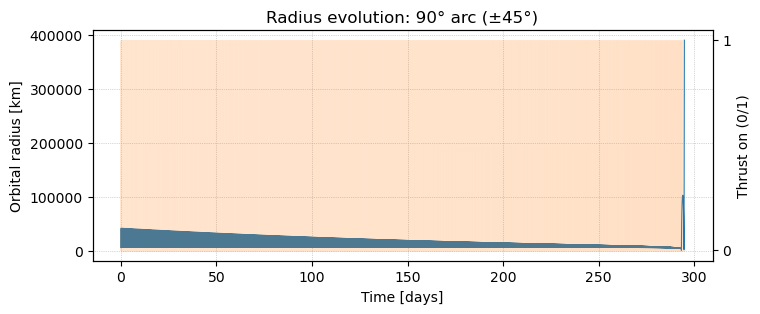

180° arc (±90°): r_min = 1562.7 km, r_max = 393093.4 km


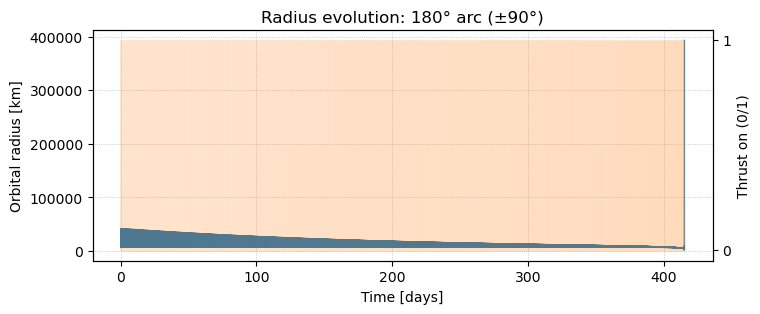

In [42]:
import numpy as np

def plot_radius_evolution(res, label):
    history = res["history"]
    if history is None:
        print(f"No history recorded for {label}.")
        return
    dt = res["dt"]
    times_days = np.arange(len(history["r"])) * dt / 86400.0
    radii = np.array(history["r"])
    thrust = np.array(history["thrust_on"], dtype=float)

    fig, ax1 = plt.subplots(figsize=(8, 3))
    ax1.plot(times_days, radii, color="tab:blue", linewidth=0.8)
    ax1.set_xlabel("Time [days]")
    ax1.set_ylabel("Orbital radius [km]")
    ax1.set_title(f"Radius evolution: {label}")
    ax1.grid(True, linestyle=":", linewidth=0.5)

    ax2 = ax1.twinx()
    ax2.fill_between(times_days, 0, thrust, color="tab:orange", alpha=0.2)
    ax2.set_ylabel("Thrust on (0/1)")
    ax2.set_yticks([0, 1])

    print(f"{label}: r_min = {radii.min():.1f} km, r_max = {radii.max():.1f} km")
    plt.show()

plot_radius_evolution(res_90, "90° arc (±45°)")
plot_radius_evolution(res_180, "180° arc (±90°)")